In [ ]:
import numpy as np
import pandas as pd
import os
from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import text_classifier
from tflite_model_maker.text_classifier import DataLoader
from tflite_model_maker.config import QuantizationConfig
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow as tf
assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')

In [2]:
# Remove and stopwords and special characters
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [4]:
dataset = pd.read_csv('/tmp/saved_model/toxic/toxic.csv', encoding="ISO-8859-1")

In [5]:
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
sentences = [] 
labels = []
for index, item in dataset.iterrows():
    sentence = item['comment_text'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    if item['toxic'] == 1:
        labels.append("toxic")
    elif item['severe_toxic'] == 1:
        labels.append("toxic")
    elif item['obscene'] == 1:
        labels.append("toxic")
    elif item['threat'] == 1:
        labels.append("toxic")
    elif item['insult'] == 1:
        labels.append("toxic")
    elif item['identity_hate'] == 1:
        labels.append("toxic")
    else:
        labels.append("safe")

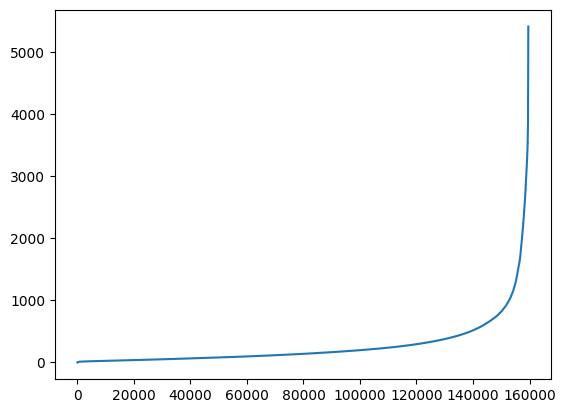

In [17]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

import matplotlib.pyplot as plt
plt.plot(xs,newys)
#plt.axis([100000, 160000, 50, 1000])
plt.show()

#print(newys[26000])

In [12]:
vocab_size = 10000
oov_tok = ""

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
wc=tokenizer.word_counts
print(wc)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



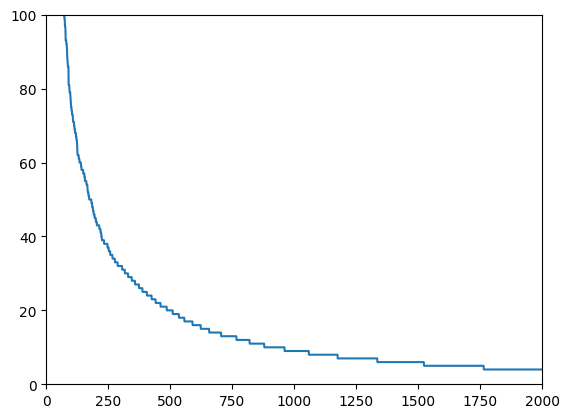

9
4


In [8]:
import matplotlib.pyplot as plt
wc = tokenizer.word_counts
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])

plt.plot(xs,ys)
plt.axis([0,2000,0,100])
plt.show()
print(ys[1000])
print(ys[2000])

In [18]:
# Create new pandas dataframe and save as csv
dict = {'comments': sentences, 'label': labels}
df = pd.DataFrame(dict)
print(df)

                                                 comments label
0       explanation edits made username hardcore metal...  safe
1       daww matches background colour seemingly stuck...  safe
2       hey man  really not trying edit war  just guy ...  safe
3        cant make real suggestions improvement  wonde...  safe
4                        sir  hero  chance remember page   safe
...                                                   ...   ...
159566  second time asking  view completely contradict...  safe
159567  ashamed horrible thing put talk page  128  61 ...  safe
159568  spitzer umm  no actual article prostitution ri...  safe
159569  looks like actually put speedy first version d...  safe
159570      really dont think understand  came idea ba...  safe

[159571 rows x 2 columns]


In [20]:
df.to_csv('/tmp/saved_model/toxic/cleanuped_toxic.csv', index=False)

In [25]:
# Load data from csv and split to test, train
spec = model_spec.get('average_word_vec')
#spec = model_spec.get('mobilebert_classifier')
spec.num_words = 1200
spec.seq_len = 200
spec.wordvec_dim = 6
spec.dropout_rate = 0.2
spec.learning_rate = 0.00001

In [26]:
data = DataLoader.from_csv(
    filename="/tmp/saved_model/toxic/cleanuped_toxic.csv",
    text_column='comments',
    label_column='label',
    model_spec=spec,
    delimiter=',',
    shuffle=True,
    is_training=True)

train_data, test_data = data.split(0.9)

In [27]:
# Build the model
# model = text_classifier.create(train_data, model_spec=spec, epochs=50, validation_data=test_data)
model = text_classifier.create(train_data, model_spec=spec, epochs=10)

4487/4487 [==============================] - 21s 5ms/step - loss: 0.3113 - accuracy: 0.8989
Epoch 2/2
4487/4487 [==============================] - 21s 5ms/step - loss: 0.2476 - accuracy: 0.9158
Epoch 3/3
4487/4487 [==============================] - 21s 5ms/step - loss: 0.2275 - accuracy: 0.9252
Epoch 4/4
4487/4487 [==============================] - 20s 5ms/step - loss: 0.2200 - accuracy: 0.9290
Epoch 5/5
4487/4487 [==============================] - 20s 5ms/step - loss: 0.2200 - accuracy: 0.9296
Epoch 6/6
4487/4487 [==============================] - 21s 5ms/step - loss: 0.2178 - accuracy: 0.9308
Epoch 7/7
4487/4487 [==============================] - 21s 5ms/step - loss: 0.2178 - accuracy: 0.9317
Epoch 8/8
4487/4487 [==============================] - 21s 5ms/step - loss: 0.2170 - accuracy: 0.9323
Epoch 9/9
4487/4487 [==============================] - 21s 5ms/step - loss: 0.2160 - accuracy: 0.9326
Epoch 10/10
4487/4487 [==============================] - 21s 5ms/step - loss: 0.2167 - accur

In [28]:
loss, acc = model.evaluate(test_data)

499/499 [==============================] - 3s 3ms/step - loss: 0.2152 - accuracy: 0.9328


In [29]:
# Save model
export_dir = '/tmp/saved_model/toxic/'
model.export(export_dir=export_dir, export_format=ExportFormat.SAVED_MODEL)

In [30]:
# This will export to TFLite format with the model only. 
# if you see a .json file in this directory, it is NOT the JSON model for TFJS
# See below for how to generate that.
# Please note that if you run this cell to create the tflite model then the 
# export to TFJS will fail. You'll need to rerun the model training first
model.export(export_dir=export_dir)

In [31]:
# If you want the labels and the vocab, for example for iOS, you can use this
model.export(export_dir=export_dir, export_format=[ExportFormat.LABEL, ExportFormat.VOCAB])

# You can find your files in colab by clicking the 'folder' tab to the left of
# this code window, and then navigating 'up' a directory to find the root
# directory listing -- and from there you should see /mm_spam/

In [18]:
# Use this section for export to TFJS
# Please note that if you run the above cell to create the tflite model then the 
# export to TFJS will fail. You'll need to rerun the model training first
#model.export(export_dir="/tmp/saved_model/spam/tfjs/", export_format=[ExportFormat.TFJS, ExportFormat.LABEL, ExportFormat.VOCAB])